# 1) Inialization

## 1.1) Import utilities

In [3]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [6]:
# Indices of different variables
PHQ_idx = slice(0, 30)
PHCLDLIQ_idx = slice(30, 60)
PHCLDICE_idx = slice(60, 90)
#TPHYSTND_idx = slice(90, 120)
TPHYSTND_idx = slice(30,60)

## 1.2) Define models

In [26]:
# Config and data files
# config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
# data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
#              '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
#              '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
# data_ref = ['','4K','3Kw1']
# dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
#            'weak_loss_0':mse,'weak_loss_1':mse}
# NNarray = ['JNNL','JNNC','MLRL0','JNNL0.01']

# Config and data files for POG experiment
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/101_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/107_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/110_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/113_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/119_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/122_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/125_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/101_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/107_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/110_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/113_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/119_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/122_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/125_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/102_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/108_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/111_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/114_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/120_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/123_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/126_valid.nc']
NNarray = ['POG101','POG104','POG107','POG110','POG113','POG119','POG122','POG125']
NNname = ['q T','RH T','q Tma','RH Tma','q Carnotmax','q TTs','RH TTs','RH Carnotmax']

# 2) Test where the generalization error for convective heating and moistening is most obvious for different types of networks
# Global mean

In [4]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    #NN[NNs] = load_model(path,custom_objects=dict_lay)
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

W1121 14:56:24.421519 22809055385408 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1121 14:56:24.422182 22809055385408 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1121 14:56:24.423449 22809055385408 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG101


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG107


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG110


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG113


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG119


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG122


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG125


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [35]:
#lat_ind = np.arange(32,36) # index over which we evaluate generalization performances
lat_ind = np.arange(15,20)
iini = 2700
iend = 2715

for isim in range(2):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate(NNarray):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
    if isim==0: diagno0 = diagno
    elif isim==1: diagno4 = diagno

isim= 0


isim= 1


## Idea = Systematic biases should be visible in the mean

In [36]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [37]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

ifig= 0  and field= PHQ
ifig= 1  and field= TPHYSTND


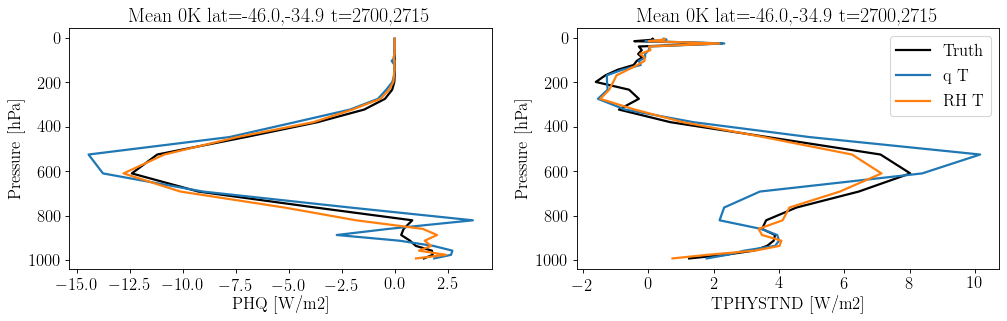

In [43]:
# NNplot = NNarray
# NNplotname = NNname
#NNarrayplot = ['POG101','POG104','POG107','POG110','POG113','POG119','POG122','POG125']
#NNplotname = ['q T','RH T','q Tma','RH Tma','q Carnotmax','q TTs','RH TTs','RH Carnotmax']
NNarrayplot = ['POG101','POG104']
NNplotname = ['q T','RH T']

option = 'full' # Full profile vs profile bias
simu = '0K'

if simu=='0K': diagno = diagno0
elif simu=='+4K': diagno=diagno4
    
f = plt.figure(num=None, figsize=(15,4), dpi=80, facecolor='w', edgecolor='k')

for ifig,field in enumerate(['PHQ','TPHYSTND']):
    print('ifig=',ifig,' and field=',field)
    ax = f.add_subplot(1,2,ifig+1)
    if option=='full': plt.plot(np.mean(diagno['truth'][field],axis=(0,1,3)),lev,label='Truth',color='k')
    elif option=='bias': plt.plot(0*lev**0,lev,label='Truth',color='k')
    for i,NNs in enumerate(NNarrayplot):
    #for i,NNs in enumerate(NNarray):
        if option=='full': plt.plot(np.mean(diagno[NNs][field],axis=(0,1,3)),lev,label=NNplotname[i])
        elif option=='bias': plt.plot(np.mean(diagno[NNs][field]-diagno['truth'][field],axis=(0,1,3)),lev,label=NNplotname[i])
    if ifig==1: plt.legend()
#     plt.ylim((0,200))
#     plt.xlim((-10,10))
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure [hPa]')
    plt.xlabel(field+' [W/m2]')
    if option=='full': plt.title('Mean '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                ' t='+str(iini)+','+str(iend))
    elif option=='bias': plt.title('Mean bias '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                  ' t='+str(iini)+','+str(iend))


# 3) Select network with the least global mean bias to test the 
# Variance and tropopause shift

In [34]:
# Config and data files for POG experiment
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/101_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/110_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/122_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/125_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/101_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/110_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/122_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/125_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/102_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/111_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/123_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/126_valid.nc']
NNarray = ['POG101','POG104','POG110','POG122','POG125']
NNname = ['q T','RH T','RH Tma','RH TTs','RH Carnotmax']

In [35]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG101


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG110


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG122


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG125


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [79]:
lat_ind = np.arange(32,36) # index over which we evaluate generalization performances
#lat_ind = np.arange(20,25) # Based on notebook 027
iini = 2500
iend = 2520

for isim in range(2):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagnotot = {}
    R2latp = {}
    diagno['truth'] = {} # Diagnostics structure for the truth
    diagnotot['truth'] = {}
    R2latp['truth'] = {}
    for i,NNs in enumerate(NNarray):
        diagno[NNs] = {} # Diagnostics structure for each NN
        diagnotot[NNs] = {}
        R2latp[NNs] = {}
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    diagnotot['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[:,:,:,np.newaxis]
                    diagnotot['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[:,:,:,np.newaxis]
                diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagnotot[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[:,:,:,np.newaxis]
                diagnotot[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[:,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    diagnotot[NNs][field] = np.concatenate((diagnotot[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[:,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
                        diagnotot['truth'][field] = np.concatenate((diagnotot['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[:,:,:,np.newaxis]),
                                                                axis=3)
        
        for istr,field in enumerate(['PHQ','TPHYSTND']):
            R2latp[NNs][field] = 1-(np.mean((diagnotot[NNs][field]-diagnotot['truth'][field])**2,axis=(1,3))/\
            np.var(diagnotot['truth'][field],axis=(1,3)))
            R2latp['truth'][field] = np.mean(diagnotot['truth'][field],axis=(1,3))**0
                                        
    if isim==0: diagno0 = diagno; R2latp0 = R2latp
    elif isim==1: diagno4 = diagno; R2latp4 = R2latp
    del(diagnotot)

isim= 0


/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:54: RuntimeWarning: divide by zero encountered in true_divide



isim= 1


In [57]:
sqrtvar0 = {};
sqrtvar4 = {};
# Variance (sqrt) of the diagnosed fields
for isim in range(2):
    print('isim=',isim)
    for i,NNs in enumerate(np.concatenate((['truth'],NNarray))):
        sqrtvar0[NNs] = {};
        sqrtvar4[NNs] = {};
        for istr,field in enumerate(['PHQ','TPHYSTND']):
            sqrtvar0[NNs][field] = np.std(diagno0[NNs][field],axis=(0,1,3))
            sqrtvar4[NNs][field] = np.std(diagno4[NNs][field],axis=(0,1,3))

isim= 0
isim= 1


In [80]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

ifig= 0  and field= PHQ
ifig= 1  and field= TPHYSTND


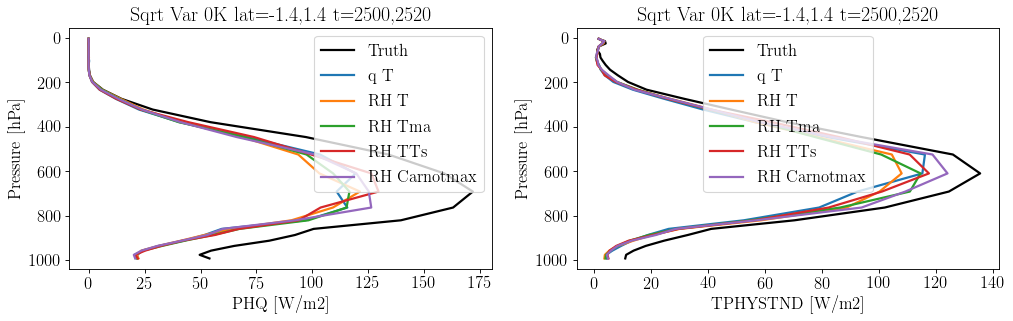

In [81]:
option = 'full' # Full profile vs profile bias
simu = '0K'
VAR = 'sqrtvar'

if simu=='0K': 
    if VAR=='sqrtvar': toplot = sqrtvar0
elif simu=='+4K':
    if VAR=='sqrtvar': toplot = sqrtvar4
    
f = plt.figure(num=None, figsize=(15,4), dpi=80, facecolor='w', edgecolor='k')

for ifig,field in enumerate(['PHQ','TPHYSTND']):
    print('ifig=',ifig,' and field=',field)
    ax = f.add_subplot(1,2,ifig+1)
    if option=='full': plt.plot(toplot['truth'][field],lev,label='Truth',color='k')
    elif option=='bias': plt.plot(0*lev**0,lev,label='Truth',color='k')
    for i,NNs in enumerate(NNarray):
        if option=='full': plt.plot(toplot[NNs][field],lev,label=NNname[i])
        elif option=='bias': plt.plot(toplot[NNs][field]-toplot[NNs]['truth'],lev,label=NNname[i])
    plt.legend()
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure [hPa]')
    plt.xlabel(field+' [W/m2]')
    if option=='full': plt.title('Sqrt Var '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                ' t='+str(iini)+','+str(iend))
    elif option=='bias': plt.title('Sqrt Var bias '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                  ' t='+str(iini)+','+str(iend))

ifig= 0  and field= PHQ
ifig= 1  and field= TPHYSTND


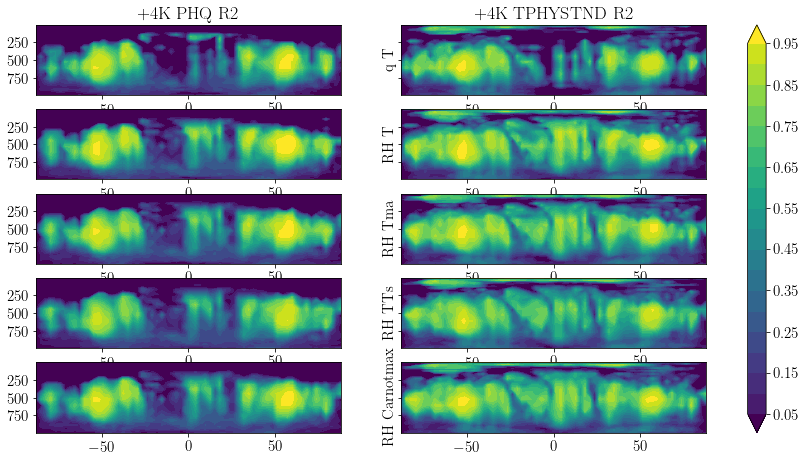

In [114]:
simu = '+4K'
lowbnd = 0

if simu=='0K': toplot = R2latp0
elif simu=='+4K': toplot = R2latp4
    
fig, axes = plt.subplots(np.size(NNarray),2, figsize=(15,7.5), sharey = True)

for ifig,field in enumerate(['PHQ','TPHYSTND']):
    print('ifig=',ifig,' and field=',field)
    for i,NNs in enumerate(NNarray):
        im = axes[i,ifig].contourf(lat, lev, np.transpose(np.maximum(lowbnd,toplot[NNs][field])), 20, vmin = lowbnd, vmax = 1, extend='both')
        if ifig==1: axes[i,ifig].set_ylabel(NNname[i]); 
        if i==0: axes[i,ifig].set_title(simu+' '+field+' R2')
axes[i,ifig].invert_yaxis()

cbar = plt.colorbar(im,ax=axes.ravel().tolist())

# 4) Diagnose upwards shift of convective heating and moistening

In [4]:
# Config and data files for POG experiment
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/101_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/101_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/102_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc']
NNarray = ['POG101','POG104']
NNname = ['q T','RH T']

In [6]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

W1120 17:56:03.658129 22858774583104 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1120 17:56:03.658774 22858774583104 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1120 17:56:03.659928 22858774583104 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG101


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [19]:
lat_ind = np.arange(32,36) # index over which we evaluate generalization performances
#lat_ind = np.arange(20,25) # Based on notebook 027
iini = 2500
iend = 2550

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp0, p0, truth0 = md0[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        inp4, p4, truth4 = md4[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md4[NNs].reshape_ngeo(truth4[:,PHQ_idx])[lat_ind,:,:,np.newaxis]-\
                md0[NNs].reshape_ngeo(truth0[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md4[NNs].reshape_ngeo(truth4[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]-\
                md0[NNs].reshape_ngeo(truth0[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md4[NNs].reshape_ngeo(p4[:,PHQ_idx])[lat_ind,:,:,np.newaxis]-\
            md0[NNs].reshape_ngeo(p0[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md4[NNs].reshape_ngeo(p4[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]-\
            md0[NNs].reshape_ngeo(p0[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                if field=='PHQ': ind_field = PHQ_idx
                elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md4[NNs].reshape_ngeo(p4[:,ind_field])[lat_ind,:,:,np.newaxis]-\
                                                    md0[NNs].reshape_ngeo(p0[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md4[NNs].reshape_ngeo(truth4[:,ind_field])[lat_ind,:,:,np.newaxis]-\
                                                             md0[NNs].reshape_ngeo(truth0[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

In [20]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [21]:
diagno['truth']['TPHYSTND'].shape

(4, 128, 30, 50)

Text(0, 0.5, '4K-0K difference in PHQ (W/m2)')

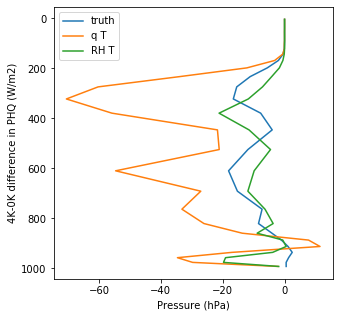

In [28]:
field = 'PHQ'

plt.figure(figsize=(5,5))
plt.plot(np.mean(diagno['truth'][field],axis=(0,1,3)),coor.lev,label='truth')
plt.plot(np.mean(diagno['POG101'][field],axis=(0,1,3)),coor.lev,label='q T')
plt.plot(np.mean(diagno['POG104'][field],axis=(0,1,3)),coor.lev,label='RH T')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Pressure (hPa)')
plt.ylabel('4K-0K difference in '+field+' (W/m2)')

In [14]:
coor.lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

# 5) Diagnose lack of generalization at high latitudes to pick best normalized temperature coordinate

In [1]:
# Config and data files for POG experiment
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/101_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/110_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/122_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/125_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/101_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/110_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/122_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/125_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/102_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/111_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/123_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/126_valid.nc']
NNarray = ['POG102','POG105','POG111','POG123','POG126']
NNname = ['q T','RH T','RH Tma','RH TTs','RH Carnotmax']

In [4]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

W1128 00:02:14.415407 22966220572480 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1128 00:02:14.416236 22966220572480 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1128 00:02:14.417433 22966220572480 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG102


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG105


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG111


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG123


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG126


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [7]:
#lat_ind = np.arange(32,36) # index over which we evaluate generalization performances
lat_ind = np.arange(0,64)
iini = 2700
iend = 2715

for isim in range(2):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate(NNarray):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
    if isim==0: diagno0 = diagno
    elif isim==1: diagno4 = diagno

isim= 0



isim= 1


In [8]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [9]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [12]:
diagno['truth'][field].shape

(64, 128, 30, 15)

ifig= 0  and field= PHQ
ifig= 1  and field= TPHYSTND


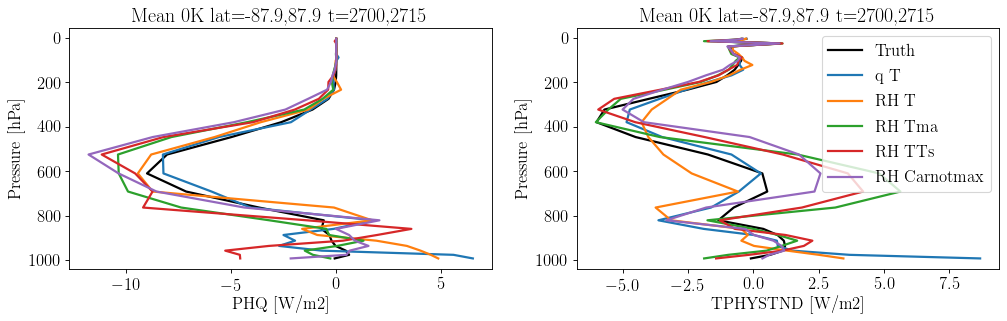

In [17]:
NNarrayplot = NNarray
NNplotname = NNname
#NNarrayplot = ['POG101','POG104','POG107','POG110','POG113','POG119','POG122','POG125']
#NNplotname = ['q T','RH T','q Tma','RH Tma','q Carnotmax','q TTs','RH TTs','RH Carnotmax']
# NNarrayplot = ['POG101','POG104']
# NNplotname = ['q T','RH T']

ilat = np.arange(45,60)

option = 'full' # Full profile vs profile bias
simu = '0K'

if simu=='0K': diagno = diagno0
elif simu=='+4K': diagno=diagno4
    
f = plt.figure(num=None, figsize=(15,4), dpi=80, facecolor='w', edgecolor='k')

for ifig,field in enumerate(['PHQ','TPHYSTND']):
    print('ifig=',ifig,' and field=',field)
    ax = f.add_subplot(1,2,ifig+1)
    if option=='full': plt.plot(np.mean(diagno['truth'][field][ilat,:,:,:],axis=(0,1,3)),lev,label='Truth',color='k')
    elif option=='bias': plt.plot(0*lev**0,lev,label='Truth',color='k')
    for i,NNs in enumerate(NNarrayplot):
        if option=='full': plt.plot(np.mean(diagno[NNs][field][ilat,:,:,:],axis=(0,1,3)),lev,label=NNplotname[i])
        elif option=='bias': plt.plot(np.mean(diagno[NNs][field][ilat,:,:,:]-\
                                              diagno['truth'][field][ilat,:,:,:],axis=(0,1,3)),lev,label=NNplotname[i])
    if ifig==1: plt.legend()
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure [hPa]')
    plt.xlabel(field+' [W/m2]')
    if option=='full': plt.title('Mean '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                ' t='+str(iini)+','+str(iend))
    elif option=='bias': plt.title('Mean bias '+simu+' lat='+'%02.1f'%coor.lat[lat_ind[0]]+','+'%02.1f'%coor.lat[lat_ind[-1]]+\
                                  ' t='+str(iini)+','+str(iend))
